In [1]:
"""
Created By    : Taylor McHone
Creation Date : 04 November 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
Perform a three pass Cressman Analysis of 500 mb heights and compare each pass by finding their differences and RMS error.

"""
__author__    = "Taylor McHone"
__contact__   = "taylor.mchone@und.edu"

In [156]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd

In [157]:
### Read in observations ###
df = pd.read_csv("RAOBs_201903131200.txt", sep=",", names=['station', 'lat', 'lon', 'height', 'wind_direction', 'wind_speed'])

#convert lat/lon to radians and add to df
df['lat_radians']=df['lat']*(np.pi/180)
df['lon_radians']=df['lon']*(np.pi/180)
df.head()

,station,lat,lon,height,wind_direction,wind_speed,lat_radians,lon_radians
0,CWPL,51.47,-90.2,5460.0,285.0,29.0,0.898321,-1.574287
1,CWQI,43.83,-66.0,5540.0,325.0,41.0,0.764978,-1.151917
2,CWSE,53.55,-113.9,5360.0,280.0,12.0,0.934624,-1.987930
3,CYAH,53.75,-73.6,5340.0,300.0,70.0,0.938114,-1.284562
4,CYBK,64.30,-96.0,5220.0,95.0,17.0,1.122247,-1.675516


In [158]:
### Set up analysis map with a 22x28 rectangular grid of points ###
#find grid points
x_step = 18.9 + np.arange(22)*1.27 #18.9,-6.3 starting pts, 22,28 number of axis pts, 1.27cm between pts
y_step = -6.3 + np.arange(28)*1.27
xx,yy = np.meshgrid(x_step,y_step)

#convert grid points to lat/lon

#known vals
map_proj=1/(15e6)
rho = 6371 * 1e5
lambda_o=-115
phi_o = 60 * (np.pi/180)

#transformation eqs
x2lon = np.arctan(yy/xx) * (180/np.pi) + lambda_o
y2lat = (180/np.pi) * ((np.pi/2) - (2*np.arctan(np.sqrt((xx/map_proj)**2+(yy/map_proj)**2)/(rho*(1+np.sin(phi_o))))))

In [159]:
### convert obs lat/long to x,y ###
#assign vars
phi = df['lat_radians']
lambdy = df['lon_radians']

#solve for image scale factor and radius of lat circle
sigma = (1+np.sin(phi_o))/(1+np.sin(phi))
r = rho * sigma * np.cos(phi) * map_proj

#lam = deviation of lon from standard lon
lam = lambdy - (lambda_o*np.pi/180)
x = r*np.cos(lam)#*map_proj
y = r*np.sin(lam)#*map_proj


In [160]:
#calculate d_min
mins = np.zeros(135) #array full of smallest distances between ob locations
for idx in range(len(x)): #loop through ob locations
    xd = x[idx] - x #find x and y distances between one ob loc and all ob locs
    yd = y[idx] - y
    
    d = (xd**2 + yd**2)**.5 #find actual distance
    d = np.sort(d)
    mins[idx] = d[1] #take minimum of distances and append to array of mins
    
    
d_min = np.average(mins) #average minimums

In [161]:
### Create function for Cressman Analysis ###
def cressman(d_ik, R):
    """
    Function to analyze the value at a given point from other data
    using a Cressman analysis technique.
    
    inputs: 
    d_ik - distance between the ith analysis point and kth observation point
    R - radius of influence
     
    returns:
      weight for a given observation point
    """
    if d_ik <= R:
        return ((R**2) - (d_ik**2)) / ((R**2) + (d_ik**2))
    elif d_ik > R:
        return 0
    else:
        print('wrong cressman')

In [162]:
### Create function for bilinear interpolation ###

def bilin_interp(x, y, a_mx):
    # (x,y) is location to interpolate to
    # a_mx is an analysis matrix
    
    x_rel = x - np.floor(x) #define relative x and y coords within a square of points (0,0), (0,1), (1,0) and (1,1)
    y_rel = y - np.floor(y)
   
    z1 = a_mx[int(np.floor(y))][int(np.floor(x))] #find analysis values from analyis matrix
    z2 = a_mx[int(np.ceil(y))][int(np.floor(x))]
    z3 = a_mx[int(np.ceil(y))][int(np.ceil(x))]
    z4 = a_mx[int(np.floor(y))][int(np.ceil(x))]
 
    answer = (x_rel-1)*(y_rel-1)*z1 - x_rel*(y_rel-1)*z2 + x_rel*y_rel*z3 - (x_rel-1)*y_rel*z4  #bilinear interpolation equation
    return answer

In [163]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin


In [164]:
#do first pass cressman analysis

d_iks = np.zeros((28,22,135))
#subtract every ob point from each analysis point
for j in range(len(xx)): 
    for k in range(len(xx[j])):
            xd = xx[j,k] - x # single grid point loc minus all observation locs
            yd= yy[j,k] - y

        #distance formula
            d_ik = ((xd**2 + yd**2)**.5)  #135x1 array containing distance between analysis and observation locations
            d_iks[j,k]=d_ik 

R = 4*d_min #find radius of influence

W = (R**2 - d_iks**2) / (R**2 + d_iks**2) #weight formula
want = d_iks<=R #boolean array

W = np.clip(W*want, 0, 10) #change -0.0 values to 0, left with all weights as a 28x22x135 array 

f_o = df['height'] #observation values
f_a1 = np.zeros((28,22))

for i in range(len(W)):
    for j in range(len(W[0])):
        faik = W[i][j] * f_o #multiply weight for a grid point by ob values
        fa_num = np.sum(faik)
        weight_sum = np.sum(W[i][j])
        
        fa = fa_num/weight_sum
        f_a1[i][j] = fa

In [165]:
#find analysis values at observation points from pass 1
#check if ob loc is in grid, if yes-->bilin interp and if not-->reverse cressman
fa_rk = np.zeros(135)
indx = (x-18.9)/1.27
indy = (y+6.3)/1.27
R = 4*d_min
for idx in range(135): #for each observation point
    if indx[idx]>=0 and indy[idx]>=0 and indx[idx]<21 and indy[idx]<27: #if observation point is in grid
        fark = bilin_interp(indx[idx], indy[idx], f_a1) #perform bilinear interp to find analysis value at that point
        
      
    else: #cressman, baby
        xd = x[idx] - xx #ob point - grid points
        yd = y[idx] - yy
        
        #distance formula
        d_ik = ((xd**2 + yd**2)**.5) #28x22
        weights=np.zeros(xx.shape)
        want = np.where(d_ik<=R)
        
        for j in want[0]:
            for k in want[1]:
                cress_a = cressman(d_ik[j,k],R)
                weights[j,k] = cress_a
        

        fark = np.sum(weights*f_a1)/np.sum(weights)
    fa_rk[idx] = fark  

C:\Users\taylo\AppData\Local\Temp\ipykernel_66852\499452553.py:27: RuntimeWarning: invalid value encountered in double_scalars
  fark = np.sum(weights*f_a1)/np.sum(weights)


In [166]:
# perform pass 2 cressman analysis

d_iks = np.zeros((28,22,135))
#subtract every ob point from each analysis point
for j in range(len(xx)): 
    for k in range(len(xx[j])):
            xd = xx[j,k] - x # single grid point loc minus all observation locs
            yd= yy[j,k] - y

        #distance formula
            d_ik = ((xd**2 + yd**2)**.5)  #135x1 array containing distance between analysis and observation locations
            d_iks[j,k]=d_ik 

R = 2.5*d_min #find radius of influence

W = (R**2 - d_iks**2) / (R**2 + d_iks**2) #weight formula
want = d_iks<=R #boolean array

W = np.clip(W*want, 0, 10) #change -0.0 values to 0, left with all weights as a 28x22x135 array 

f_o = df['height'] #observation values
f_a2 = np.zeros((28,22))

for i in range(len(W)):
    for j in range(len(W[0])):
        faik = W[i][j] * (f_o-fa_rk) #multiply weight for a grid point by ob values
        fa_num = np.sum(faik)
        weight_sum = np.sum(W[i][j])
        
        fa = fa_num/weight_sum
        f_a2[i][j] = fa
        
f_a2 = f_a2 + f_a1

In [167]:
#find analysis values at observation points from pass 2
#check if ob loc is in grid, if yes-->bilin interp and if not-->reverse cressman
fa_rk2 = np.zeros(135)
indx = (x-18.9)/1.27
indy = (y+6.3)/1.27
R = 2.5*d_min
for idx in range(135): #for each observation point
    if indx[idx]>=0 and indy[idx]>=0 and indx[idx]<21 and indy[idx]<27: #if observation point is in grid
        fark = bilin_interp(indx[idx], indy[idx], f_a2) #perform bilinear interp to find analysis value at that point
      
    else: #cressman, baby
        xd = x[idx] - xx #ob point - grid points
        yd = y[idx] - yy
        
        #distance formula
        d_ik = ((xd**2 + yd**2)**.5) #28x22
        weights=np.zeros(xx.shape)
        want = np.where(d_ik<=R)
        for j in want[0]:
            for k in want[1]:
                cress_a = cressman(d_ik[j,k],R)
                weights[j,k] = cress_a

        fark = np.sum(weights*f_a2)/np.sum(weights)
    fa_rk2[idx] = fark  

C:\Users\taylo\AppData\Local\Temp\ipykernel_66852\1030552384.py:24: RuntimeWarning: invalid value encountered in double_scalars
  fark = np.sum(weights*f_a2)/np.sum(weights)


In [168]:
#perform pass 3 cressman analysis
d_iks = np.zeros((28,22,135))
#subtract every ob point from each analysis point
for j in range(len(xx)): 
    for k in range(len(xx[j])):
            xd = xx[j,k] - x # single grid point loc minus all observation locs
            yd= yy[j,k] - y

        #distance formula
            d_ik = ((xd**2 + yd**2)**.5)  #135x1 array containing distance between analysis and observation locations
            d_iks[j,k]=d_ik 

R = 1.5*d_min #find radius of influence

W = (R**2 - d_iks**2) / (R**2 + d_iks**2) #weight formula
want = d_iks<=R #boolean array

W = np.clip(W*want, 0, 10) #change -0.0 values to 0, left with all weights as a 28x22x135 array 

f_o = df['height'] #observation values
f_a3 = np.zeros((28,22))

for i in range(len(W)):
    for j in range(len(W[0])):
        faik = W[i][j] * (f_o-fa_rk2) #multiply weight for a grid point by ob values
        fa_num = np.sum(faik)
        weight_sum = np.sum(W[i][j])
        
        fa = fa_num/weight_sum
        f_a3[i][j] = fa
        
f_a3 = f_a3 + f_a2

C:\Users\taylo\AppData\Local\Temp\ipykernel_66852\3984505245.py:29: RuntimeWarning: invalid value encountered in double_scalars
  fa = fa_num/weight_sum


In [169]:
#calculating fa at ob points after third pass
fa_rk3 = np.zeros(135)
indx = (x-18.9)/1.27
indy = (y+6.3)/1.27
R = 1.5*d_min
for idx in range(135): #for each observation point
    if indx[idx]>=0 and indy[idx]>=0 and indx[idx]<21 and indy[idx]<27: #if observation point is in grid
        fark = bilin_interp(indx[idx], indy[idx], f_a3) #perform bilinear interp to find analysis value at that point
      
    else: #cressman, baby
        xd = x[idx] - xx #ob point - grid points
        yd = y[idx] - yy
        
        #distance formula
        d_ik = ((xd**2 + yd**2)**.5) #28x22
        weights=np.zeros(xx.shape)
        want = np.where(d_ik<=R)
        for j in want[0]:
            for k in want[1]:
                cress_a = cressman(d_ik[j,k],R)
                weights[j,k] = cress_a

        fark = np.sum(weights*f_a3)/np.sum(weights)
    fa_rk3[idx] = fark  

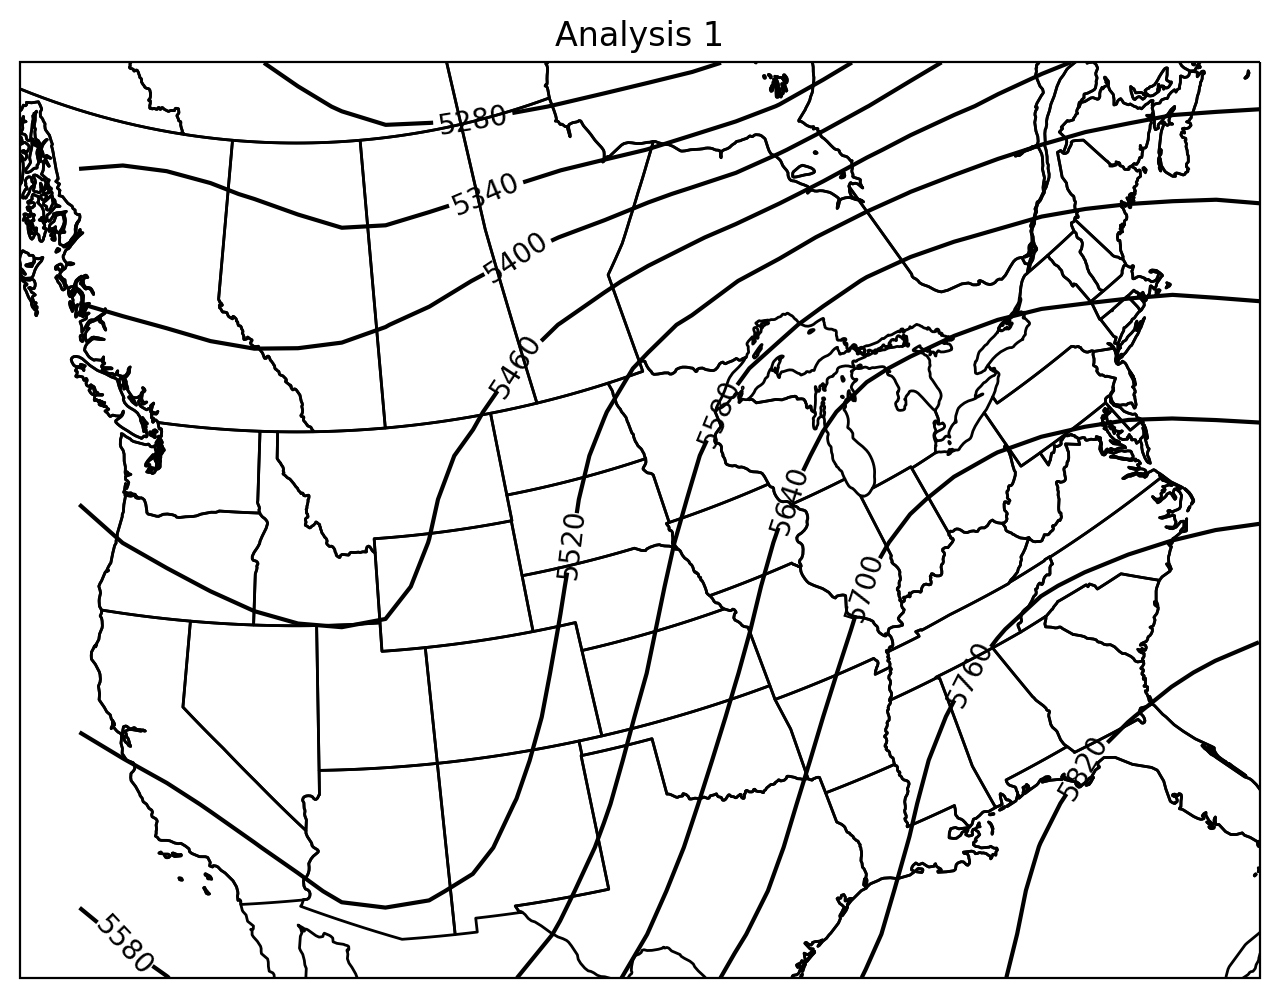

In [170]:
### Plot First analysis, no successive corrections ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x2lon,y2lat,f_a1,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis 1')

plt.show()


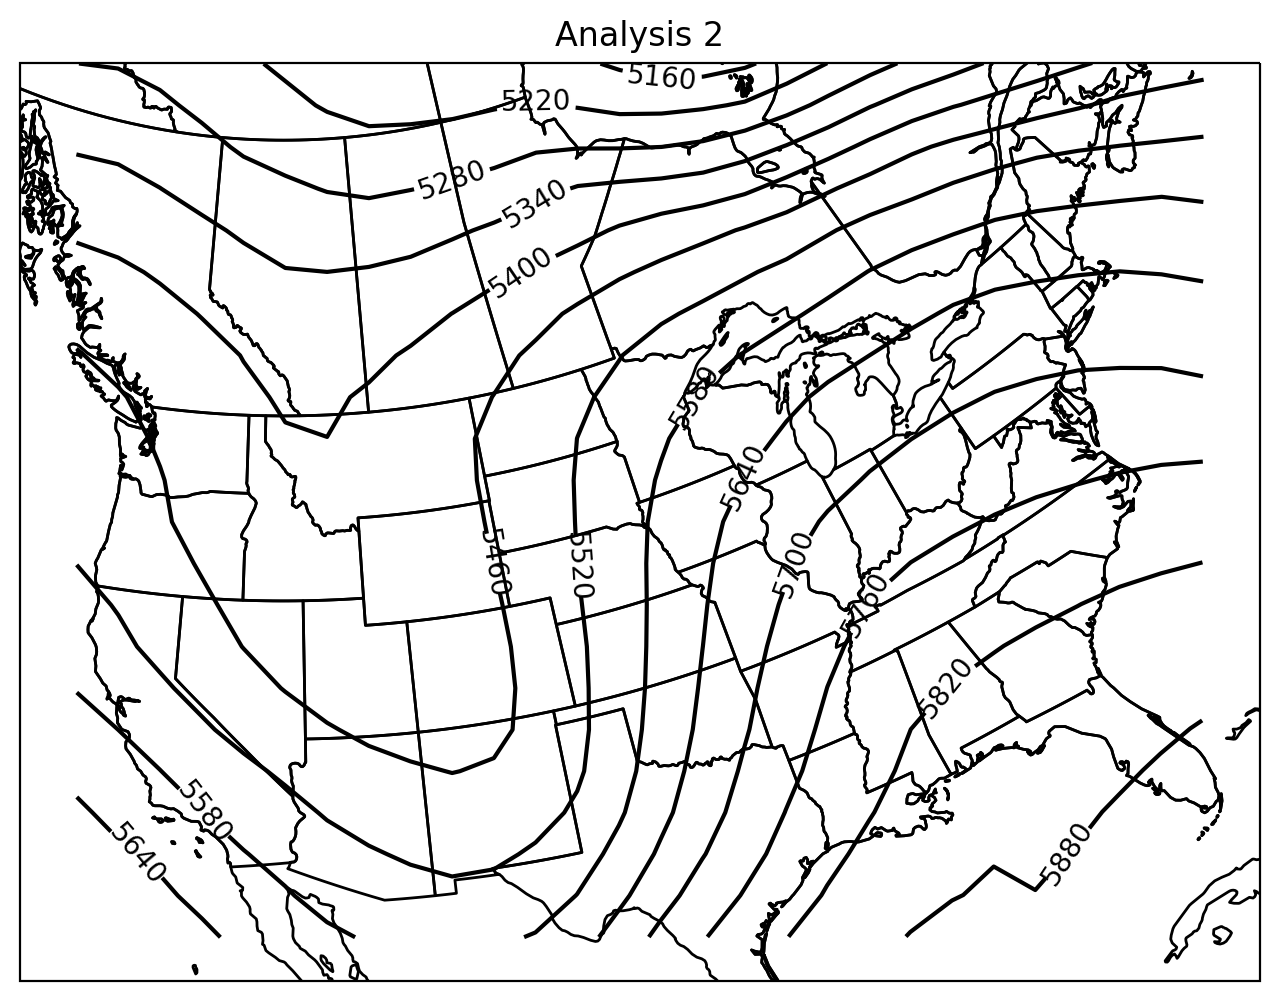

In [171]:
#plot second analysis
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)


cs1 = ax1.contour(x2lon,y2lat,f_a2,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis 2')

plt.show()

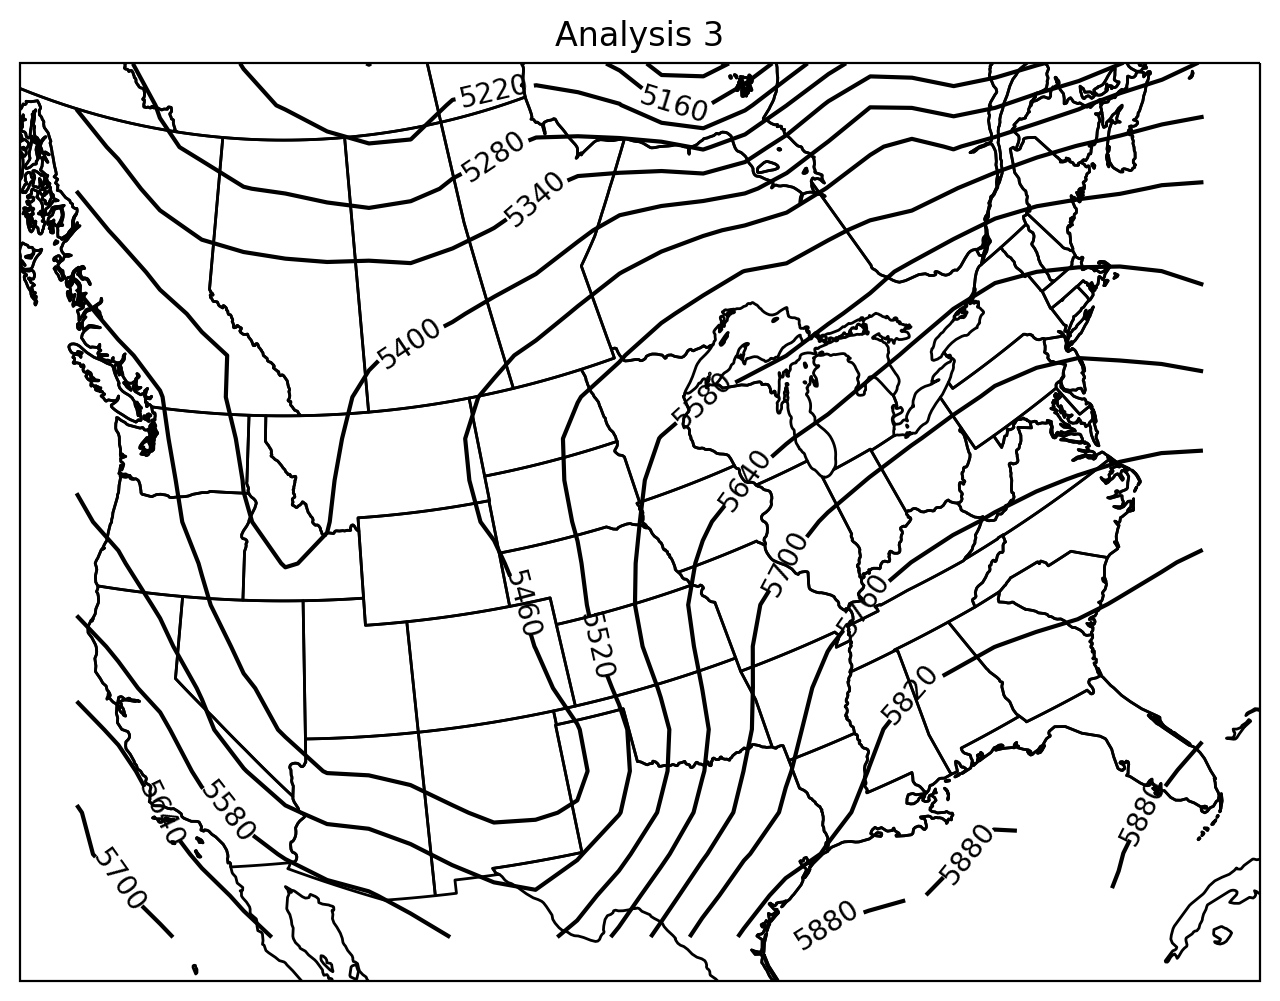

In [172]:
#plot third analysis
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)


cs1 = ax1.contour(x2lon,y2lat,f_a3,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis 3')

plt.show()

In [173]:
### Calculate Analysis Differences
diff2_1 = f_a2 - f_a1
diff3_1 = f_a3 - f_a1
diff3_2 = f_a3 - f_a2

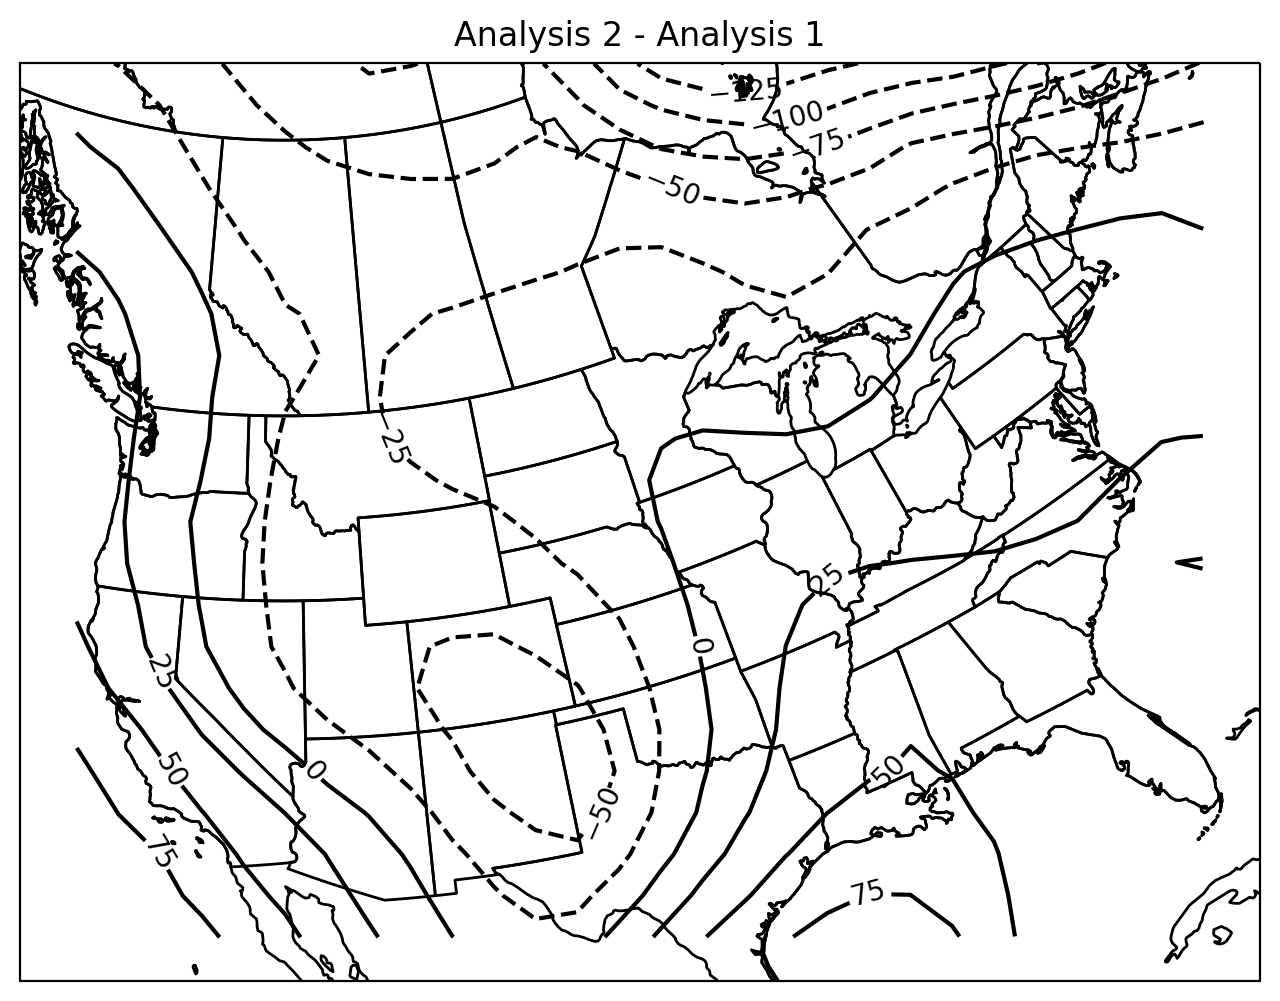

In [174]:
#plot difference between analysis 2 and analysis 1

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)


cs1 = ax1.contour(x2lon,y2lat,diff2_1,colors='k',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title('Analysis 2 - Analysis 1')

plt.show()

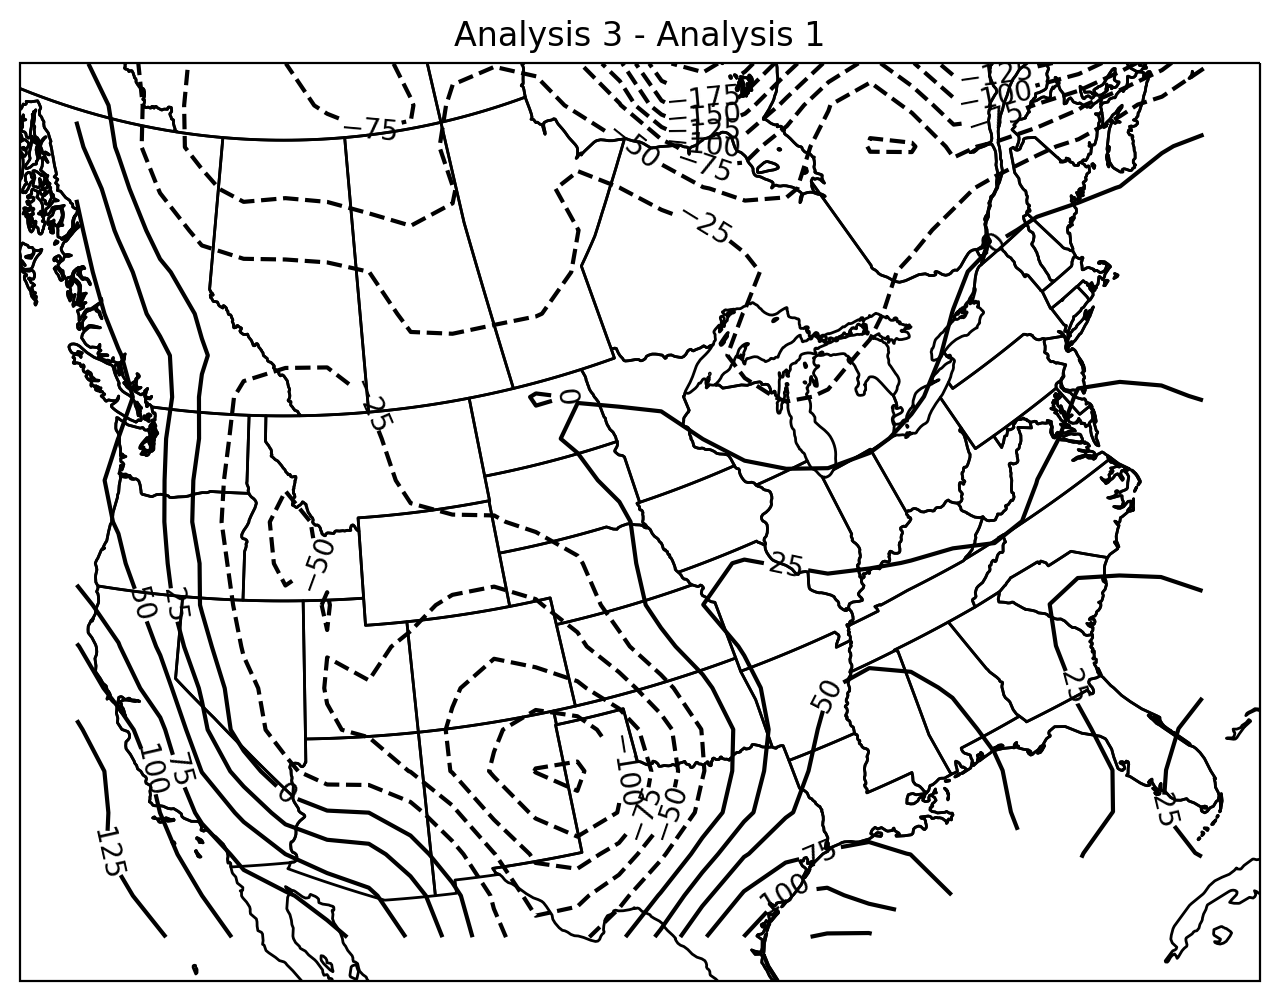

In [175]:
#plot difference between analysis 3 and analysis 1

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)


cs1 = ax1.contour(x2lon,y2lat,diff3_1,colors='k',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title('Analysis 3 - Analysis 1')

plt.show()

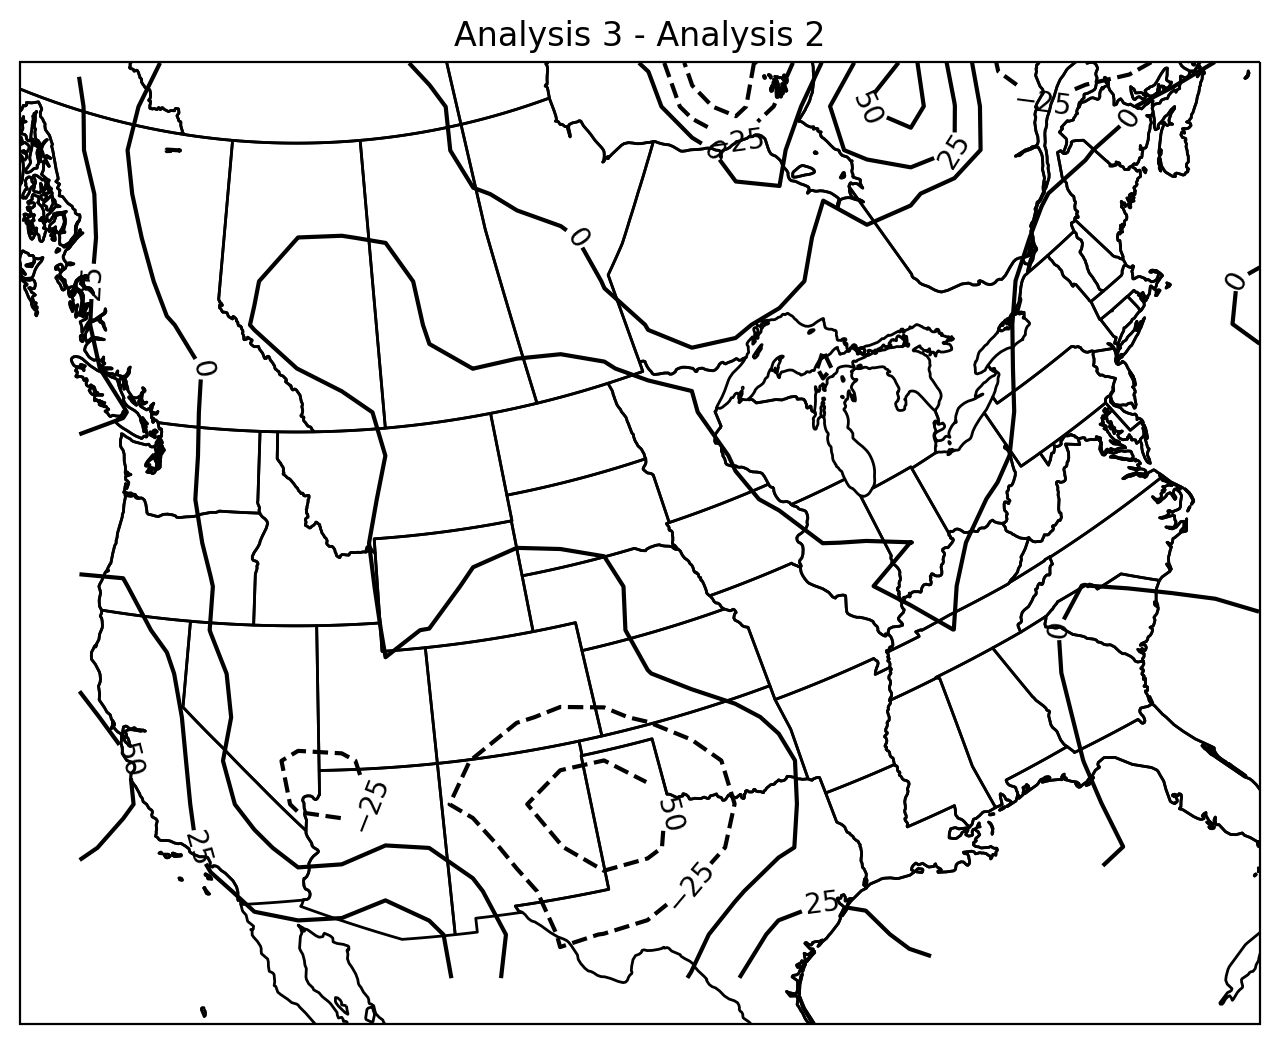

In [176]:
#plot difference between analysis 3 and analysis 2

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)


cs1 = ax1.contour(x2lon,y2lat,diff3_2,colors='k',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title('Analysis 3 - Analysis 2')

plt.show()

In [124]:
#Calculate RMS Values
d1 = f_o - fa_rk
d1 = d1[~np.isnan(d1)]
rms1 = (np.sum(d1**2)/len(d1))**.5

d2 = f_o - fa_rk2
d2 = d2[~np.isnan(d2)]
rms2 = (np.sum(d2**2)/len(d2))**.5

d3 = f_o - fa_rk3
d3 = d3[~np.isnan(d3)]
rms3 = (np.sum(d3**2)/len(d3))**.5

print('RMS1: ', rms1, ' RMS2: ', rms2, ' RMS3: ', rms3)

RMS1:  74.54329800402634  RMS2:  35.1276612658171  RMS3:  11.681749880587475


In [140]:
rms = np.array((rms1,rms2,rms3))

In [154]:
### Store the analyses in text files ###
'''
a_file = open("analysis1.txt", "w") #shape
for row in f_a1:
    np.savetxt(a_file, row)

a_file.close()

a_file = open("analysis2.txt", "w") #shape
for row in f_a2:
    np.savetxt(a_file, row)

a_file.close()

a_file = open("analysis3.txt", "w") #shape
for row in f_a3:
    np.savetxt(a_file, row)

a_file.close()
'''

In [151]:
### Store the difference fields in text files ###
'''
a_file = open("diff2-1.txt", "w") #shape
for row in diff2_1:
    np.savetxt(a_file, row)

a_file.close()

a_file = open("diff3-1.txt", "w") #shape
for row in diff3_1:
    np.savetxt(a_file, row)

a_file.close()

a_file = open("diff3-2.txt", "w") #shape
for row in diff3_2:
    np.savetxt(a_file, row)

a_file.close()
'''

In [155]:
### Store RMS values in text file ###
'''
np.savetxt('rms_vals.txt', rms)
'''

In [ ]:
### In a separate text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

    There is a trough over the west and a ridge in the east for all three analyses.


2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    The later analyses have more height lines and are less smooth than the earlier analyses. The first analysis is the
    smoothest of all. This is because the smaller scale features become more visible.




3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    
    As you increase the number of passes, there are more analysis values available at different heights and therefore
    more height lines on the plots.  Having more heights is desirable because you can see 
    smaller scale features. The lines also become less smooth as the number of passes increases. This is not always
    desirable because it can make a plot more difficult to read and the plot may not be accurate.

'''